In [1]:
%load_ext autoreload
%load_ext rich
%autoreload 2
import numpy as np
from rich import print
from pathlib import Path
from functools import reduce
from Matrix import Drift, Quad, Bend, ThinQuad, Gamma0, Sextupole, Sben, EntranceEdge, ExitEdge, transport, transport2, ListMultiply
from scipy.optimize import minimize, root_scalar, minimize_scalar
from scipy.constants import m_e,c,e
from scipy.special import i1,k1,kn
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt
from pygpt import gdftopandas

plt.style.use('/Users/tianzhe/Beams/lib/BDplotter.mplstyle')

Global variable Gamma0 set to 9.241


## LSC calculation

reference:
    
https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.24.051303

In [2]:
def convert_delta_to_energy(delta, gamma):
    """
    convert the last coordinate in beam from delta (trace space) to energy (in eV)
    """
    mc2 = 0.51099895e6
    BG0 = np.sqrt(gamma**2 - 1)
    p0c = BG0 * mc2
    pc = (delta + 1) * p0c
    energy = np.sqrt(pc*pc + mc2*mc2)
    return energy
    
def convert_energy_to_delta(energy):
    """
    convert the last coordinate in beam from delta (trace space) to energy (in eV)
    """
    mc2 = 0.51099895e6
    assert np.mean(energy) > mc2
    gamma = energy / mc2
    BG = np.sqrt(gamma**2 - 1)
    delta = BG / BG.mean() - 1
    return delta
        
def convert_gamma_to_p(gamma):
    mc2 = 0.51099895e6
    E = gamma * mc2
    return np.sqrt(E*E - mc2*mc2)

def convert_dist_to_hist(z, bins = 128, n_points = 1001):
    """
    given 1D distribution z, calculate smoothened 1D histogram 
    return density with n_points
    """
    hist, bin_edges = np.histogram(z, bins=bins, density=True)
    zs_center   = (bin_edges[1:] + bin_edges[:-1]) / 2
    hist_smooth = savgol_filter(hist, window_length=10, polyorder=2)

    zs_extended = np.linspace(zs_center.min() - zs_center.std(), zs_center.max() + zs_center.std(), n_points)
    hist_extended = np.zeros(n_points)
    condition = ( zs_extended >= zs_center.min() )& ( zs_extended <= zs_center.max() )
    hist_extended[condition] = np.interp(zs_extended[condition], zs_center, hist_smooth)
    
    hist_extended = hist_extended / np.trapz(hist_extended,zs_extended)
    return zs_extended, hist_extended

In [3]:
def track_beam_w_LSC(beam, Leff, gamma=9.241, charge=100e-15):
    """
    here gamma is gamma_0
    """
    delta = beam[:,5]
    energy = convert_delta_to_energy(delta, gamma)

    Rb = (beam[:,0].std() + beam[:,2].std()) / 2 * 1.747
    z0 = 119.916983 * np.pi

    # convert to density 
    zn, histn = convert_dist_to_hist(beam[:,4])

    # calculate LSC impedance
    I_k = np.fft.fft(histn * c * charge)
    k = np.fft.fftfreq(len(I_k), d=(zn[1]-zn[0])/2/np.pi)
    xi = k * Rb / gamma

    condition_negative = (xi < 0)
    K1 = k1(xi).astype('complex128')
    K1[condition_negative] = -1 * k1(abs(xi[condition_negative])) - 1j * np.pi * i1(abs(xi[condition_negative]))

    impedance = 1j * z0 / np.pi / gamma / Rb  * np.real(1 - 2 * i1(xi) * K1)/xi
    impedance[0] = 0
    
    # apply kick
    delta_energy = - np.real(np.fft.ifft(impedance * Leff * I_k))
    energy_new = energy + np.interp(beam[:,4], zn, delta_energy)
    delta_new = convert_energy_to_delta(energy_new)
    
    return np.c_[beam[:,:5], delta_new]


def track_drift_w_lsc(beam, drift_length, gamma=9.241, charge=100e-15, n_segments=None, return_beam_list=False):
    if n_segments is None:
        n_drifts = int(np.ceil(drift_length / 0.1))
    else:
        n_drifts = int(n_segments)
        
    dz = drift_length / n_drifts

    if return_beam_list:
        beam_list = []
    
    beam2 = np.copy(beam)
    
    for i in range(n_drifts):
        D1 = Drift(dz)
        beam2 = transport2(beam2, *D1)
        beam2 = track_beam_w_LSC(beam2, dz, gamma, charge)
        if return_beam_list:
            beam_list.append(beam2)
    
    if not return_beam_list:
        return beam2
    else:
        return beam_list
    
def track_quad_w_lsc(beam, quad_k1, quad_length, gamma=9.241, charge=100e-15):
    beam2 = np.copy(beam)
    Q1    = Quad(quad_k1, quad_length)
    beam2 = transport2(beam2, *Q1)
    beam2 = track_beam_w_LSC(beam2, quad_length, gamma, charge)    
    return beam2


def track_bend_w_lsc(beam, bend_rho, bend_theta, gamma=9.241, charge=100e-15, n_segments=2):
    assert bend_rho * bend_theta > 0
    B1_E1 = EntranceEdge(bend_rho)
    B1_h  = Bend(bend_rho, bend_theta/n_segments)
    B1_E2 = ExitEdge(bend_rho)

    beam2 = np.copy(beam)
    beam2 = transport2(beam2, *B1_E1)
    
    for i in range(n_segments):
        beam2 = transport2(beam2, *B1_h)
        beam2 = track_beam_w_LSC(beam2, bend_rho * bend_theta / n_segments)

    beam2 = transport2(beam2, *B1_E2)
    
    return beam2

def track_compressor_w_lsc(beam, bend_rho, bend_theta,
                       q1_k1, q2_k1, q3_k1,
                       d1_length, d2_length, quad_length,
                       gamma=9.241, charge_in=100e-15, slit_width=None, compressor_type='ach3'):
    
    beam2 = np.copy(beam)
    charge = charge_in
    # B1
    beam2 =  track_bend_w_lsc(beam2,  bend_rho,  bend_theta, gamma, charge)

    if slit_width:
        # D1
        beam2 = track_drift_w_lsc(beam2, d1_length/2, gamma, charge)
        assert abs(slit_width) > 20e-6
        condition = (abs(beam2[:,0]) < slit_width)
        beam2 = beam2[condition,:]
        charge = len(beam2) / len(beam) * charge_in
        print(f"slit used. charge left {charge}.")
        beam2 = track_drift_w_lsc(beam2, d1_length/2, gamma, charge)

    else:
        # D1
        beam2 = track_drift_w_lsc(beam2, d1_length, gamma, charge)
    
 
    
    # Q1
    beam2 =  track_quad_w_lsc(beam2, q1_k1, quad_length, gamma, charge)
    # D2
    beam2 = track_drift_w_lsc(beam2, d2_length, gamma, charge)
    # Q2
    beam2 =  track_quad_w_lsc(beam2, q2_k1, quad_length, gamma, charge)
    # D2
    beam2 = track_drift_w_lsc(beam2, d2_length, gamma, charge)
    # Q3 (same as Q1)
    beam2 =  track_quad_w_lsc(beam2, q3_k1, quad_length, gamma, charge)
    # D1
    beam2 = track_drift_w_lsc(beam2, d1_length, gamma, charge)
    
    if compressor_type == 'ach3':
        # B2
        beam2 =  track_bend_w_lsc(beam2,  bend_rho,  bend_theta, gamma, charge)
    elif compressor_type == 'dog3':
        # B2
        beam2 =  track_bend_w_lsc(beam2, -bend_rho, -bend_theta, gamma, charge)
        
    return beam2

In [4]:
def load_gdf_screen_to_ts(filename):
    _,_,dat = gdftopandas(filename)
    
    if 'Bx' in dat.keys():
        p = dat['G'] * np.sqrt(dat['Bx'] ** 2 + dat['By'] ** 2 + dat['Bz'] ** 2)
    elif 'GBx' in dat.keys():
        p = np.sqrt(dat['GBx'] ** 2 + dat['GBy'] ** 2 + dat['GBz'] ** 2)
        
    if 'z' in dat.keys():
        if dat['z'].std() > 1e-9:
            zeta = dat['z']
        else:
            zeta = - dat['t']*c
    else:
        zeta = - dat['t']*c
    zeta = zeta - zeta.mean()
    delta = p / p.mean() - 1
    
    if 'xp' in dat.keys():
        xp = dat['xp']
        yp = dat['yp']
    elif 'Bx' in dat.keys():
        xp = dat['Bx'] / dat['Bz']
        yp = dat['By'] / dat['Bz']
    elif 'GBx' in dat.keys():
        xp = dat['GBx'] / dat['GBz']
        yp = dat['GBy'] / dat['GBz'] 
    else:
        raise ValueError
    
    return np.c_[dat['x'], xp, dat['y'], yp, zeta, delta]

def calc_chirp_from_ts(beam):
    return np.mean(beam[:,4]* beam[:,5]) / np.mean(beam[:,4]**2)


def calc_emittance(beam, direction="x"):
    if direction == "x":
        x = beam[:,0]
        xp = beam[:,1]
    elif direction == "y":
        x = beam[:,2]
        xp = beam[:,3]
    else:
        raise ValueError
    x = x - x.mean()
    xp = xp - xp.mean()
    x2m = np.mean(x*x)
    xp2m = np.mean(xp*xp)
    xxpm = np.mean(x*xp)
    return np.sqrt(x2m * xp2m - xxpm * xxpm)

def print_beam(beam, BG=9.18):
    print(f"X RMS     : {beam[:,0].std()*1e6:.3f} μm")
    print(f"Y RMS     : {beam[:,2].std()*1e6:.3f} μm")
    print(f"Z RMS     : {beam[:,4].std()*1e6:.3f} μm / {beam[:,4].std()/c*1e15:.3f} fs")
    print(f"X emit_n  : {calc_emittance(beam,'x')*BG*1e9:.4f} nm")
    print(f"Y emit_n  : {calc_emittance(beam,'y')*BG*1e9:.4f} nm")
    print(f"delta RMS : {beam[:,5].std()*1e4:.3f} * (10^-4)")
    print(f"chirp     : {np.mean(beam[:,4]*beam[:,5])/np.mean(beam[:,4]*beam[:,4]):.3f} m^-1")

## load GPT

In [5]:
beam0 = load_gdf_screen_to_ts("/Users/tianzhe/Beams/GPT/compareLSC/lsc.screen.1.000e-02 m.gdf")
beam1 = load_gdf_screen_to_ts("/Users/tianzhe/Beams/GPT/compareLSC/lsc.screen.6.000e-01 m.gdf")

In [6]:
beam2 = track_drift_w_lsc(beam0,0.59, n_segments=6)

/var/folders/9q/89ldym6x6cn42rmljbqmy2940000gn/T/ipykernel_46175/2419697512.py:23: RuntimeWarning: invalid value encountered in multiply
  impedance = 1j * z0 / np.pi / gamma / Rb  * np.real(1 - 2 * i1(xi) * K1)/xi


In [7]:
zeta0, delta0 = beam0[:,4], beam0[:,5]
zeta1, delta1 = beam1[:,4], beam1[:,5]
zeta2, delta2 = beam2[:,4], beam2[:,5]

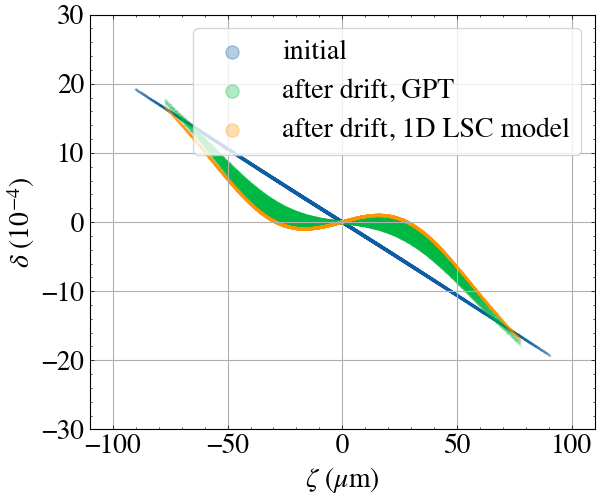

In [8]:
fig, ax = plt.subplots(figsize=(6.5,5.5))
ax.scatter(zeta0*1e6, delta0*1e4,s=0.1,alpha=0.3,rasterized=True,label='initial')
ax.scatter(zeta1*1e6, delta1*1e4,s=0.1,alpha=0.3,rasterized=True,label='after drift, GPT')
ax.scatter(zeta2*1e6, delta2*1e4,s=0.1,alpha=0.3,rasterized=True,label='after drift, 1D LSC model')


ax.set_xlabel("$\\zeta$ ($\\mu$m)")
ax.set_ylabel("$\\delta$ ($10^{-4}$)")
ax.set_xlim(-110,110)
ax.set_ylim(-30,30)
# ax.set_title("LPS comparison in a 0.6m drift")
ax.grid()
ax.legend(markerscale=30)
fig.tight_layout()
plt.show()